In [1]:
import tensorflow as tf
print(tf.__version__)

2.18.0


In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from sklearn.preprocessing import MinMaxScaler

In [ ]:
# Load and preprocess the data
df = pd.read_csv('df_concat_withBSMprice.csv')
df['quote_datetime'] = pd.to_datetime(df['quote_datetime'])
df['option_type_num'] = df['option_type'].map({'C': 1, 'P': 0})
df['implied_volatility'] = df['implied_volatility'] / 100
df['risk_free_rate'] = df['risk_free_rate'] / 100

In [6]:
df.head()

,underlying_symbol,quote_datetime,root,expiration,strike,option_type,open,high,low,close,...,gamma,theta,vega,rho,open_interest,risk_free_rate,time_to_maturity,option_price,BS_calculated_option_price,option_type_num
0,^SPX,2024-07-26 10:30:00,SPX,2024-08-16,200.0,C,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0314,-0.0047,24,0.0549,0.083333,5250.00,5255.04291,1
1,^SPX,2024-07-26 11:30:00,SPX,2024-08-16,200.0,C,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0202,-0.0117,24,0.0549,0.083333,5245.90,5249.47791,1
2,^SPX,2024-07-26 12:30:00,SPX,2024-08-16,200.0,C,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0160,-0.0184,24,0.0549,0.083333,5269.65,5273.57791,1
3,^SPX,2024-07-26 13:30:00,SPX,2024-08-16,200.0,C,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0141,-0.0210,24,0.0549,0.083333,5284.75,5288.17291,1
4,^SPX,2024-07-26 14:30:00,SPX,2024-08-16,200.0,C,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0034,-0.0269,24,0.0549,0.083333,5258.90,5263.01291,1


In [12]:
# Calculate Moneyness
df['moneyness'] = df['active_underlying_price'] / df['strike']

# List of features based on theoretical importance
features = [
    'active_underlying_price',  # S
    'strike',                   # K
    'time_to_maturity',         # T
    'implied_volatility',       # σ
    'risk_free_rate',           # r
    'option_type_num',          # Option type (Call or Put)
    'moneyness'                 # S/K
]

In [13]:
# Drop rows with missing values in the selected features and target variable
df = df.dropna(subset=features + ['option_price'])

# Sort the data by 'quote_datetime'
df = df.sort_values('quote_datetime').reset_index(drop=True)

In [16]:
# Initialize the scaler
scaler = MinMaxScaler()

# Fit the scaler on the features and transform
df[features] = scaler.fit_transform(df[features])

In [18]:
# Separate the dataset into Calls and Puts
call_df = df[df['option_type'] == 'C']
put_df = df[df['option_type'] == 'P']
call_df.head()

,underlying_symbol,quote_datetime,root,expiration,strike,option_type,open,high,low,close,...,theta,vega,rho,open_interest,risk_free_rate,time_to_maturity,option_price,BS_calculated_option_price,option_type_num,moneyness
0,^SPX,2024-07-26 10:30:00,SPX,2024-08-16,0.000000,C,0.0,0.0,0.0,0.0,...,0.0000,0.0314,-0.0047,24,0.990099,0.010638,5250.000,5255.042910,1.0,0.927974
1,^SPX,2024-07-26 10:30:00,SPX,2025-03-21,0.194915,C,0.0,0.0,0.0,0.0,...,0.0000,1.2297,15.5946,1,0.643564,0.120567,3013.100,3064.707170,1.0,0.059783
5,^SPX,2024-07-26 10:30:00,SPXW,2024-09-06,0.412712,C,0.0,0.0,0.0,0.0,...,-0.7376,3.6322,5.0911,0,1.000000,0.021277,429.900,430.476367,1.0,0.021514
6,^SPX,2024-07-26 10:30:00,SPXW,2024-12-20,0.610169,C,0.0,0.0,0.0,0.0,...,-0.0136,0.3357,0.0523,0,0.836634,0.074468,0.375,0.000000,1.0,0.009793
7,^SPX,2024-07-26 10:30:00,SPX,2025-03-21,0.186441,C,0.0,0.0,0.0,0.0,...,0.0000,1.1326,15.0046,1,0.643564,0.120567,3109.250,3160.284083,1.0,0.062928


In [19]:
def prepare_data(df, features, sequence_length):
    X = []
    y = []
    grouped = df.groupby(['root', 'strike', 'expiration'])
    for _, group in grouped:
        group = group.sort_values('quote_datetime')
        data = group[features + ['option_price']].values
        for i in range(len(data) - sequence_length):
            X.append(data[i:i+sequence_length, :])
            y.append(data[i+sequence_length, -1])
    X = np.array(X)
    y = np.array(y)
    return X, y

# Define sequence length
sequence_length = 5

# Prepare data for Calls
X_call, y_call = prepare_data(call_df, features, sequence_length)

# Prepare data for Puts
X_put, y_put = prepare_data(put_df, features, sequence_length)


In [20]:
# Define test size
test_size = 0.2

# Split data for Calls
X_train_call, X_test_call, y_train_call, y_test_call = train_test_split(
    X_call, y_call, test_size=test_size, shuffle=False
)

# Split data for Puts
X_train_put, X_test_put, y_train_put, y_test_put = train_test_split(
    X_put, y_put, test_size=test_size, shuffle=False
)


In [21]:
# Get the number of features for Calls
num_features_call = X_call.shape[2]

# Build the LSTM model for Calls
model_call = Sequential()
model_call.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features_call)))
model_call.add(Dropout(0.2))
model_call.add(LSTM(32))
model_call.add(Dropout(0.2))
model_call.add(Dense(1))

# Compile the model
model_call.compile(optimizer='adam', loss='mean_squared_error')


/Users/beeeeen_yin/Documents/GitHub/MLA_OptionsPricing/.venv/lib/python3.12/site-packages/keras/src/layers/rnn/rnn.py:204: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [22]:
# Get the number of features for Puts
num_features_put = X_put.shape[2]

# Build the LSTM model for Puts
model_put = Sequential()
model_put.add(LSTM(64, return_sequences=True, input_shape=(sequence_length, num_features_put)))
model_put.add(Dropout(0.2))
model_put.add(LSTM(32))
model_put.add(Dropout(0.2))
model_put.add(Dense(1))

# Compile the model
model_put.compile(optimizer='adam', loss='mean_squared_error')


In [23]:
# Train the model for Calls
history_call = model_call.fit(
    X_train_call, y_train_call,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_call, y_test_call)
)


Epoch 1/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 2075964.3750 - val_loss: 53.8218
Epoch 2/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 1224856.8750 - val_loss: 80.5757
Epoch 3/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 735436.3750 - val_loss: 93.6036
Epoch 4/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 24s 1ms/step - loss: 452366.2812 - val_loss: 326.0186
Epoch 5/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 306345.5312 - val_loss: 159.9146
Epoch 6/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 227568.9375 - val_loss: 201.8383
Epoch 7/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 220998.1250 - val_loss: 571.3854
Epoch 8/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 223500.1875 - val_loss: 536.3533
Epoch 9/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 198033.5938 - val_loss: 263.1566
Epoch 10/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 160772.2031 - val_loss: 171.6395
Epoch 11/50
19051/19

In [24]:
# Train the model for Puts
history_put = model_put.fit(
    X_train_put, y_train_put,
    epochs=50,
    batch_size=16,
    validation_data=(X_test_put, y_test_put)
)


Epoch 1/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 180626.6875 - val_loss: 163245.2344
Epoch 2/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 118906.8516 - val_loss: 95458.1094
Epoch 3/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 84094.1797 - val_loss: 56520.8203
Epoch 4/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 27s 1ms/step - loss: 64331.7695 - val_loss: 50767.8164
Epoch 5/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 50055.7227 - val_loss: 54332.5859
Epoch 6/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 40938.1992 - val_loss: 25601.4707
Epoch 7/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 33119.2930 - val_loss: 76898.1797
Epoch 8/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 25s 1ms/step - loss: 29212.9336 - val_loss: 13326.6240
Epoch 9/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 26s 1ms/step - loss: 25683.3477 - val_loss: 16205.1426
Epoch 10/50
19051/19051 ━━━━━━━━━━━━━━━━━━━━ 28s 1ms/step - loss: 21523.6426 - val_loss: 18434.0000
Epoch 

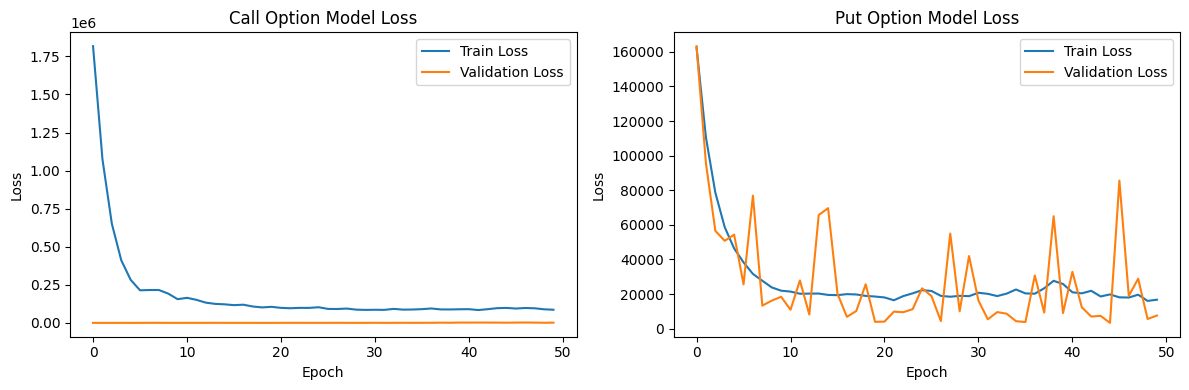

In [25]:
# Plot for Calls
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history_call.history['loss'], label='Train Loss')
plt.plot(history_call.history['val_loss'], label='Validation Loss')
plt.title('Call Option Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

# Plot for Puts
plt.subplot(1, 2, 2)
plt.plot(history_put.history['loss'], label='Train Loss')
plt.plot(history_put.history['val_loss'], label='Validation Loss')
plt.title('Put Option Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()


In [26]:
# Evaluate the model
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Predictions for Calls
y_pred_call = model_call.predict(X_test_call)

# Evaluate the model
mse_call = mean_squared_error(y_test_call, y_pred_call)
rmse_call = np.sqrt(mse_call)
mae_call = mean_absolute_error(y_test_call, y_pred_call)
r2_call = r2_score(y_test_call, y_pred_call)

print('Call Option Model Evaluation Metrics:')
print(f'RMSE: {rmse_call}')
print(f'MAE: {mae_call}')
print(f'R² Score: {r2_call}')

# Predictions for Puts
y_pred_put = model_put.predict(X_test_put)

# Evaluate the model
mse_put = mean_squared_error(y_test_put, y_pred_put)
rmse_put = np.sqrt(mse_put)
mae_put = mean_absolute_error(y_test_put, y_pred_put)
r2_put = r2_score(y_test_put, y_pred_put)

print('\nPut Option Model Evaluation Metrics:')
print(f'RMSE: {rmse_put}')
print(f'MAE: {mae_put}')
print(f'R² Score: {r2_put}')

2382/2382 ━━━━━━━━━━━━━━━━━━━━ 1s 496us/step
Call Option Model Evaluation Metrics:
RMSE: 40.8032297137164
MAE: 37.44457068426716
R² Score: 0.7857858365451944
2382/2382 ━━━━━━━━━━━━━━━━━━━━ 1s 493us/step

Put Option Model Evaluation Metrics:
RMSE: 87.27255385523544
MAE: 41.85856116772067
R² Score: 0.9641460487555856
